# Week 8 - Trees and Ensembles

### Aims

By the end of this notebook you will be able to understand: 

>* The Basics of Decision Trees
>* Cost Complexity Pruning
>* Ensembles (bagging, random forests, voting)


1. [Setup](#setup)

2. [Decision Trees](#intro)

3. [Ensembles](#majVot)

As usual, during workshops, you will complete the worksheets together in teams of 2-3, using **pair programming**. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- In some Exercises, you will see some hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given.

# Setup <a id='setup'></a>

Let's load the packages needed for this workshop (more will be loaded through the workshop).

In [97]:
# Display plots inline
%matplotlib inline  

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# some new libraries and modules for this week
from sklearn.tree import export_graphviz, DecisionTreeClassifier

# Introduction to Decision Trees <a id='intro'></a>

Decision trees provide a simple, interpretable model for both classification and regression tasks. They are able to capture nonlinear relationships between the features and target variables, by learning simple decision rules and assuming piecewise constant approximations. The deeper the tree, the more complex the decision rules and the better the fit on the training data.

Decision trees require little preprocessing and feature engineering. While other methods often require standardization, this is not the case for trees, and some tree and algorithm combinations can even support missing values. Decision trees able to handle both numerical and categorical data. However, sklearn does not implent more advanced methods for multi-class categorical features, and one-hot encoding must be used; if the number of features is large, this may result in many features and complex trees that suffer from overfitting. 

To learn the decision tree, sklearn uses an optimized version of the Classification and Regression Tree (CART) algorithm, which is a greedy algorithm where locally optimal decisions are made at each node, starting from the root down to the leaves. At each node/step, CART uses binary spliting and finds the threshold yielding the largest information gain. For more information on sklearn's implementation of decision trees, see https://scikit-learn.org/stable/modules/tree.html#tree-classification.

The sklearn implementation supports both regression tasks through [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) and classication through [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). In this workshop, we will focus on **classification**. 

Let's start by loading data to explore the `DecisionTreeClassifier`.

##  Palmer Penguin Data

The palmer penguins dataset contains information for 344 penguins from 3 different species and from 3 islands in the Palmer Archipelago, Antarctica.

In [98]:
# Load the data
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Let's start with some basic EDA.

In [99]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Notice that there are some missing values. For simplicity, we will remove them.  

In [100]:
# dropna values
penguins_rm = penguins.dropna()
penguins_rm.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


We will focus on the task of classifying species. Notice that there are four numerical features and two categorical features. For simplicity, we will focus on the numerical features only. Before any further EDA, we split our data into a training and test set.

In [101]:
# Split into train and test sets

# Feature matrix and response vector
X, y = penguins_rm.drop(["island", "sex", "species"], axis=1), penguins_rm['species']

# Stratify split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, test_size = 0.2, random_state=0)

### 🚩 Exercise 1 (CORE)

- Draw a pairplot, setting `hue = "species"`, to explore the numerical features relation with species. 
- Comment on any relationships that you observe.


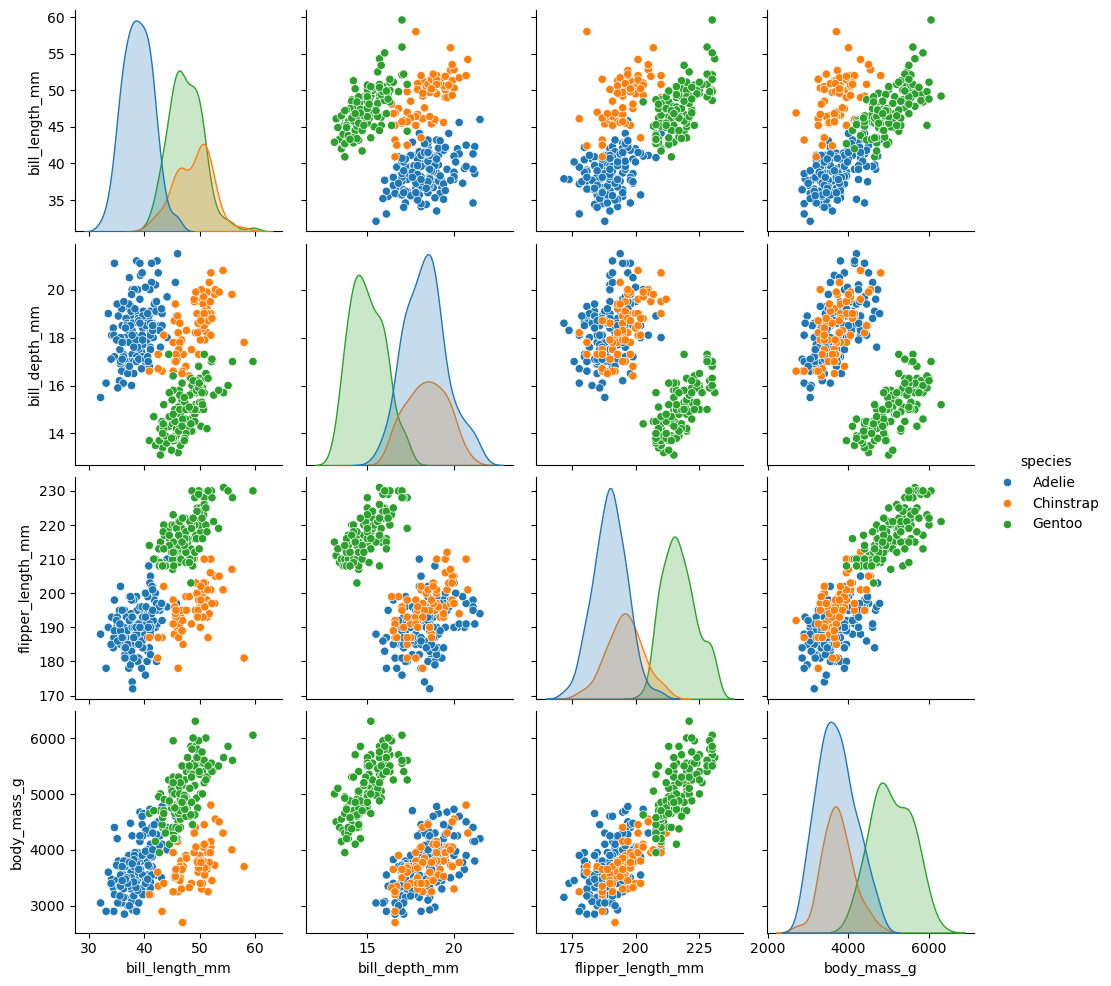

In [102]:
# Pair plot
sns.pairplot(penguins, hue='species')

Generally appears to be a clear distinction between gentoo and other species. Adelie and Chinstrap have a lot of similarities.

## Classification Trees

Recall from lectures, the decision tree has a number of parameters that affect the shape of the tree:

- `max_depth` : the maximum depth of the tree. 

- `min_samples_split` : the minimum number of samples required to split an internal node

- `min_samples_leaf`: the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

- `max_leaf_nodes`: the maximum number of leaf nodes. 

- `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

As usual, once we create our `DecisionTreeClassifier` object, we can fit the tree by calling `.fit()`. Once fit, the tree will have a number of attributes and we can call additional methods such as `.predict()` or  `.predict_proba()` to predict hard or soft labels, respectively, for any new data. 

Let's fit our first decision tree. In the following code, we fit a simple tree of depth 2 by specifying `max_depth=2`. 

**NOTE:** If you are using noteable, [inkscape](https://inkscape.org/release/inkscape-1.4/) is not installed, which is required in order to export the notebook to PDF, when graphviz images are included. In this case, please instead you the `plot_tree` function below to plot the tree instead (delete the code using graphviz). If you are running locally, please install graphviz.

In [103]:
# Decsion tree with max depth of 2
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X_train, y_train)

# Plot the decision tree
tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True, feature_names=X_train.columns, class_names = tree_clf.classes_
 )

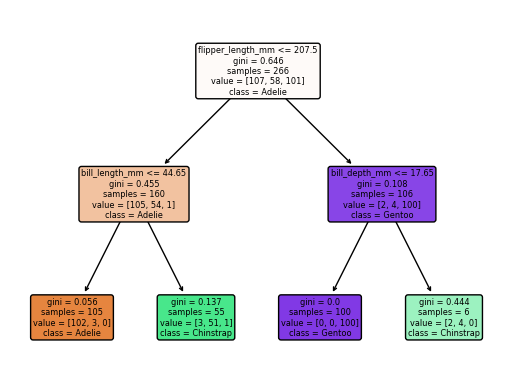

In [104]:
from sklearn.tree import plot_tree

plot_tree(tree_clf, rounded = True, filled = True, feature_names=X_train.columns, class_names = tree_clf.classes_)
plt.show()

### 🚩 Exercise 2  (CORE)

Below, we print out the first five rows of the test data. Based on the fitted tree above (not using `.predict()`!!), what is the classified species of each penguin/row? what path along the decision tree is taken to classify the penguin?

In [105]:
# Print first five rows
X_test.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
62,37.6,17.0,185.0,3600.0
60,35.7,16.9,185.0,3150.0
283,54.3,15.7,231.0,5650.0
107,38.2,20.0,190.0,3900.0
65,41.6,18.0,192.0,3950.0


107 Adelie

62 Adelie

60 Adelie

65 Adelie



283 Gentoo

### 🚩 Exercise 3  (CORE) 

Fit a new decision tree, again with a depth 2, but change the criterion to measure the quality of a split to entropy. How has the tree stucture changed?

**Hint:** when creating the decision tree object, set the option `criterion`.

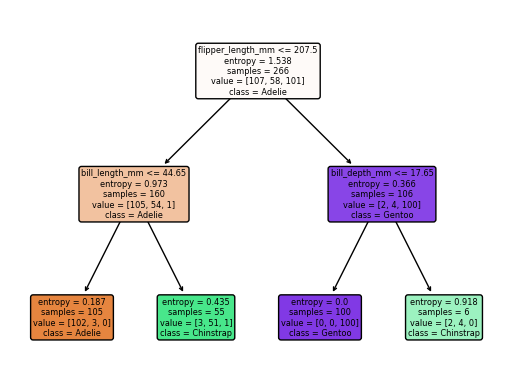

In [106]:
# new deciion tree, with depth 2, criterion measures the quality of a split to entropy

tree_clf2 = DecisionTreeClassifier(max_depth = 2, criterion = 'entropy')
tree_clf2.fit(X_train, y_train)

# Plot the decision tree
plot_tree(tree_clf2, rounded = True, filled = True, feature_names=X_train.columns, class_names = tree_clf.classes_)
plt.show()

### 🚩 Exercise 4  (CORE) 

- Create two functions, one to compute the Gini index and another to compute the entropy, based on a vector of counts representing the number of observations in each category. 

- For each leaf node in the trees fitted above, use your functions to compute the Gini index and entropy based on the counts reported. If your functions are correct, it should match the numbers reported in the tree.

**RECALL**

- **Gini Index**: is a measure of total variance across the $C$ classes, defined as:

$G(R_m) = \sum_{c=1}^{C} \widehat{p}_{m,c} (1 - \widehat{p}_{m,c}) = 
1 - \sum_{c=1}^{C} \widehat{p}_{m,c}^2$ 

where $\widehat{p}_{m,c}$ is the proportion of training observations in the $m$ th region (belonging to $m$ th node) coming from the $c$ th class.

- **Entropy**: is an information theoretic measure defined as:

$H(R_m) = - \sum_{c=1}^{C} \widehat{p}_{m,c} \log_2 \widehat{p}_{m,c}.$

In [107]:
# Define a function to compute the gini index

def gini_index(y):
    """
    y -- vector of counts representing the number of observations in each category
    

    Returns:
    Gini index - measure of total variance across C categories defined as:
    1 - sum(p_{m,c}^2)
    where p_{m,c} is the proportion of observations in the mth region coming from the cth class
    """

    # Total number of observations
    N = np.sum(y)

    # Proportion of observations in each class
    p = y / N

    # Gini index
    G = 1 - np.sum(p**2)

    return G

# Define a function to compute the gini index

def entropy(y):
    """
    y -- vector of counts representing the number of observations in each category
    

    Returns:
    entropy -- information theoretic measure.
    """

    # Total number of observations
    N = np.sum(y)

    # Proportion of observations in each class
    p = y / N

    # Entropy
    E = -np.sum(p * np.log2(p))

    return E

In [108]:
# Compute the gini index for each leaf node

print(gini_index(y_train.value_counts()))

# Compute the entropy for each leaf node
print(entropy(y_train.value_counts()))


0.6464752105828481
1.5380673038461024


Observe that our values match the values in the tree. I'm unsure how to do it for each leaf node.

Note that our fitted `DecisionTreeClassifier` stores the tree as an attribute, which can be accessed by calling `.tree_`. For more information on how `sklearn` stores a tree, see [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py). The fitted tree has a number of attributes, including `.impurity` providing the impurity for all nodes.    

In [109]:
# The impurity values for all nodes are accessible in the impurity attribute of the tree.
print(tree_clf.tree_.impurity)
print(tree_clf2.tree_.impurity)

[0.64647521 0.45539063 0.0555102  0.1368595  0.10822357 0.
 0.44444444]
[1.5380673  0.97342994 0.18717626 0.4350219  0.36579197 0.
 0.91829583]


### 🚩 Exercise 5 (CORE)

Trying increasing the maximum depth to 10.

- Fit and visualize the tree.

- What is the depth of the tree? **Hint**: check the available methods for a `DecisionTreeClassifier`. 

- How does the accuracy on both the train and test data compare with our previous tree with a depth of 2?

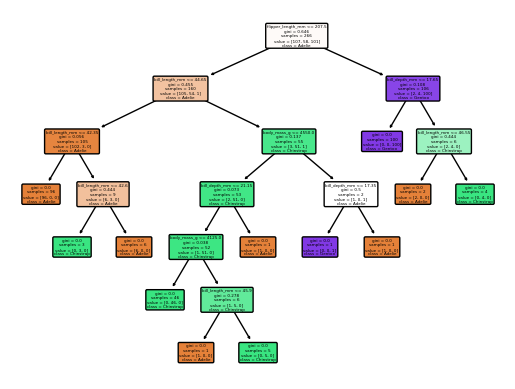

In [110]:
tree_ten = DecisionTreeClassifier(max_depth = 10)
tree_ten.fit(X_train, y_train)

# Plot the decision tree
plot_tree(tree_ten, rounded = True, filled = True, feature_names=X_train.columns, class_names = tree_clf.classes_)
plt.show()

In [111]:
# depth of the tree

print(f"there are {tree_clf.tree_.max_depth} levels in the tree")

there are 2 levels in the tree


## Cost Complexity Pruning

Instead of using cross-validation to fit and tune the tree depth and shape across a range of values, a more effective and computationally efficient strategy is **cost complexity pruning**. Recall that in cost complexity pruning, we start by constructing a complex tree, and sequentially prune back the tree by snipping off the branches that minimize the cost complexity. This produces a sequence of nested trees, with each one associated to range of values of $\alpha$ (i.e. each tree is the optimal, unique tree for this range of $\alpha$).

We can perform cost complexity pruning in `sklearn` by using the method `cost_complexity_pruning_path()` on our decision tree object. Recall that a larger value of $\alpha$ implies more regularization and more shallow trees.

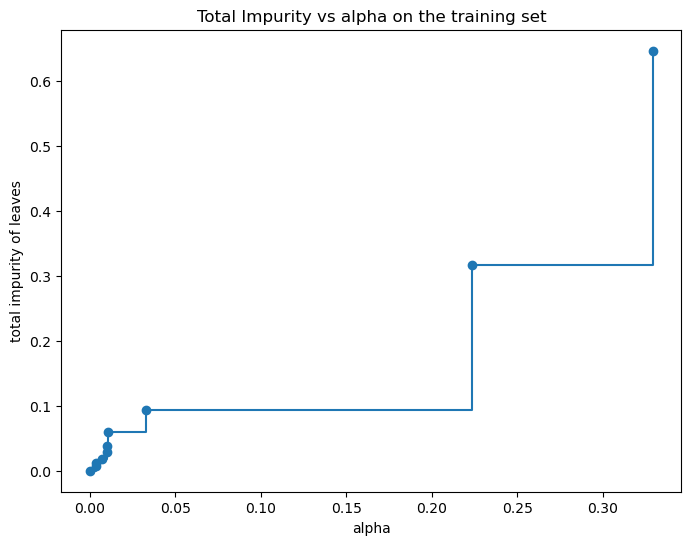

In [112]:
# Cost complexity pruning
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
path = tree_clf.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs alpha on the training set")
plt.show()

Run the following code to understand the depth and number of nodes in each tree in the sequence.

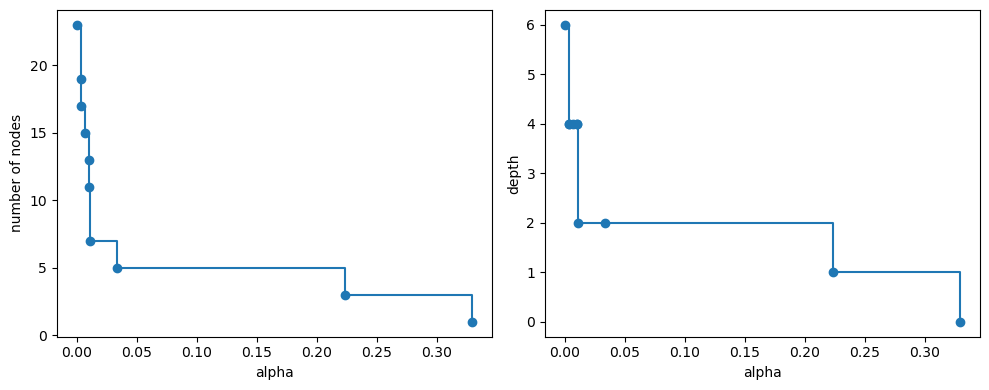

In [113]:
# Fit and store the decision tree for each value of alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Plot the depth and number of nodes for each tree for in the sequence as a function of alpha
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth")
fig.tight_layout()

Run the following code to compute the accuracy of each tree in the sequence on both the training and test set. 

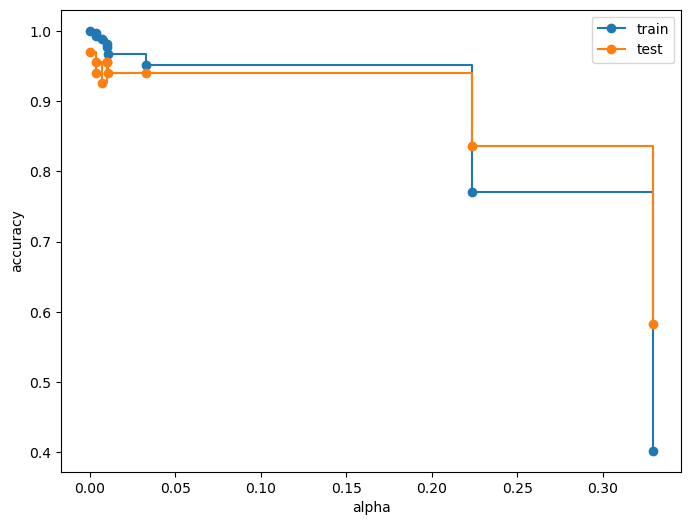

In [114]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

The training accuracy is of course a decreasing function of $\alpha$, as the tree becomes less complex as the $\alpha$ increases. Instead, the test accuracy is fairly flat for any $\alpha<0.2$. Of course, we can use the test data to choose $\alpha$, as that would lead to **data leakage**!! Instead, we need to use cross-validation to tune the value of $\alpha$. 

### 🚩 Exercise 6 (CORE)

Run the following code to compute the cross-validated accuracy across the values of $\alpha$. 

- Add the cross-validated accuracy to the figure above with train and test accuracy.

- What is best value of $\alpha$ returned by the grid search? Based on the plot, would you choose this value or a different one? Why?

In [115]:
# Grid search
clf = DecisionTreeClassifier()
gs = GridSearchCV(clf, 
                  param_grid = {'ccp_alpha': ccp_alphas}, 
                  cv = KFold(5, shuffle=True, random_state=42),)
gs.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.0036871 , 0.0037594 , 0.00709593, 0.01002506,
       0.01006848, 0.01095596, 0.03310162, 0.22370923, 0.32942935])})

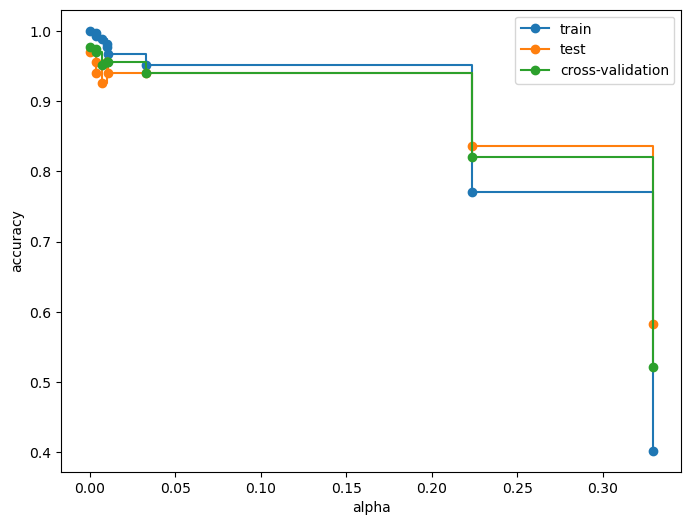

In [116]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.plot(ccp_alphas, gs.cv_results_['mean_test_score'], marker="o", label="cross-validation", drawstyle="steps-post")
ax.legend()
plt.show()

In [117]:
# best param

gs.best_params_

{'ccp_alpha': 0.0}

gridsearch returned that the best $\alpha$ was $\alpha = 0.00375$. I would choose any value from 0.05 to 0.20 as the loss in accuracy we retain high accuracy yet the tree is much simpler.

### 🚩 Exercise 7 (CORE)

For your chosen value of $\alpha$, fit and visualize the tree. How does it compare to the shallow and deep tree that we initialy fit?

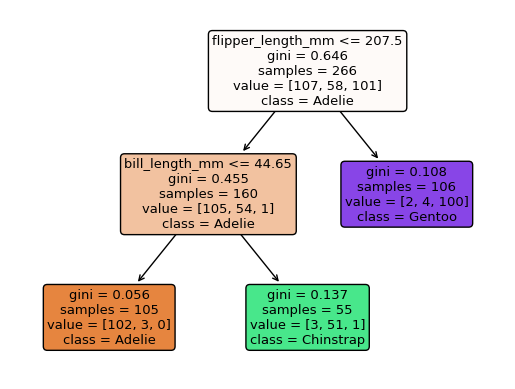

In [118]:
# NOTE: call your tree clf or change to your name of the pruned tree when computing feature importances before exercise 12

clf = DecisionTreeClassifier(ccp_alpha=0.15)

# Fit the tree
clf.fit(X_train, y_train)

# Visualize the tree
plot_tree(clf, rounded = True, filled = True, feature_names=X_train.columns, class_names = clf.classes_)
plt.show()


Has a depth of 2 but based on the gridsearch it has an accuracy of 90%+

# Ensembles <a id='majVot'></a> 

Ensembles combine the predictions of several base estimators to improve generalization and robustness, compared with a single estimator. A number of ensemble methods are available in `sklearn`, and for an overview, see 
https://scikit-learn.org/stable/modules/ensemble.html#. However, we only have time to cover a subset of ensemble methods, namely, **bagging**, **random forests**, and **voting**.

## Bagging

A bagging classifier is an ensemble of base classifiers, each fit on random subsets of a dataset. Their predictions are then pooled or aggregated to form a final prediction. To apply bagging to decision trees, we simply construct 
(i) decision trees using bootstrapped training sets,
(ii) agregated the predictions (either by averaging the probabilities or by majority vote).

Bagging is typically used as a way to reduce the variance of a high-variance estimator (e.g. a decision tree). The parameter `n_estimators` contols the number of bootstrapped datasets, and hence the number of estimators in the ensemble. While bagging is when sampling is performed with replacement, the `sklearn` implementation allows for more general constructions of the random subsets of the data: 

- Pasting is when the sampling is done without replacement and is designed to use smaller sample sizes than the training dataset (useful when the training dataset does not fit into memory). Pasting can be performed with `BaggingClassifier` by setting the options `bootstrap=FALSE` and `max_samples` either to an integer or a float representing the sample size of the random subset as a proportion of training points. 

- Random Subspaces is when random subsets of the dataset are drawn as random subsets of the features. Random Subspaces can be performed with `BaggingClassifier` by setting the options `bootstrap=FALSE` and `max_features` either to an integer or a float representing the number of features in the random subset as a proportion of the number of features in the training data. 

- Random Patches is when random subsets of the dataset are drawn based on random subsets of both the features and samples, and can be constructed by combining the options above. 

Averaging methods generally work best when the classifiers are diverse, and they have been shown to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

Note that while the default estimator in `BaggingClassifier` is a decision tree, other classifiers can be combined by specifying the option `estimator`. Also note that in `sklearn`'s implementation, the final predictions are obtained by averaging the prediction probabilities across estimators, with majority voting only used for estimators that don't provide probabilistic outputs. 

For more details, see:  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html


### 🚩 Exercise 8  (CORE)

- Fit a bagged classifier to the data that combines 10 decision trees.

- Plot the confusion matrix on the both test and training data for both your pruned tree and bagged classifier. Comment on the advantages and disadvantages of the pruned tree vs bagged classifier briefly. 

In [119]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
bc.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=0)

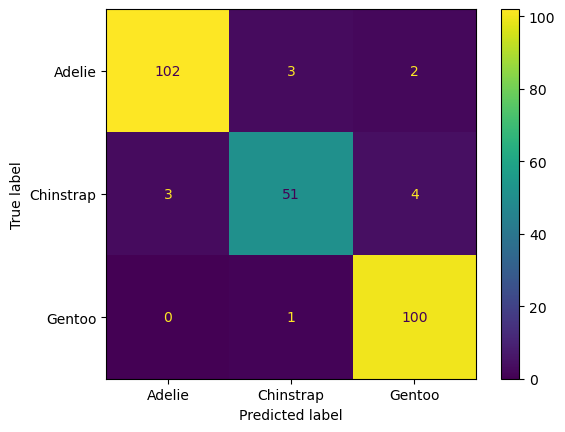

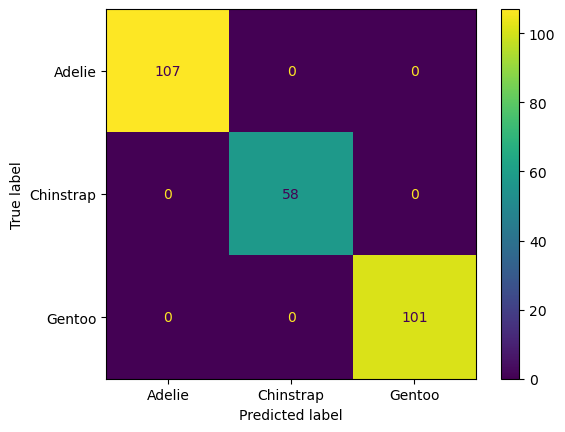

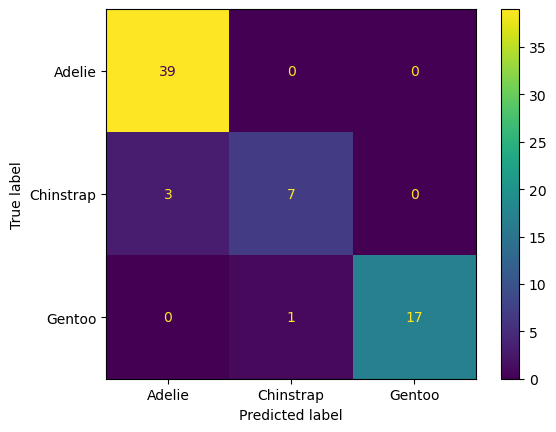

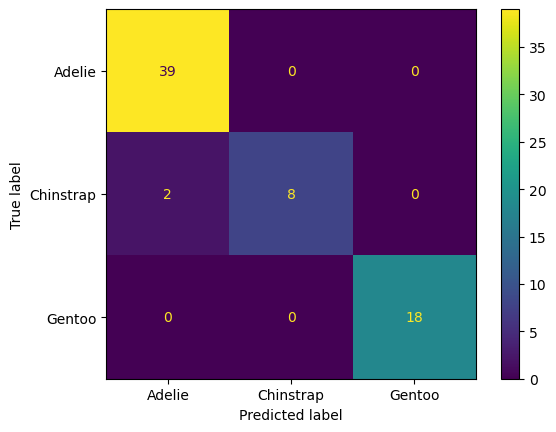

In [120]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
ConfusionMatrixDisplay.from_estimator(bc, X_train, y_train)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(bc, X_test, y_test)

the bagged classifier performed extremely well in both the test and training data set.

### 🚩 Exercise 9  (CORE)

For the range of `n_estimators` provided below: 
- Fit the bagged trees and compute the training accuracy, test accuracy, and out-of-bag scores. 
- Plot all three metrics as a function of the number of estimators. 
- Comment on the results and suggest a suitable number of estimators for this data.

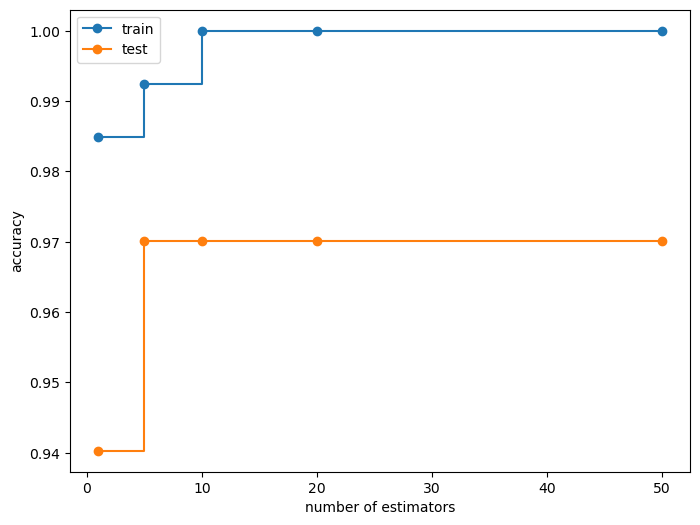

In [121]:
# Range of number of estimators
n_est = np.array([1,5,10,20,50],dtype=int)

#oobs = np.empty(n_est.shape)
train_accs = np.empty(n_est.shape)
test_accs = np.empty(n_est.shape)
for idx, num_est in enumerate(n_est):
    bc = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=num_est, random_state=0)
    bc.fit(X_train, y_train)
    train_acc = bc.score(X_train, y_train)
    test_acc  = bc.score(X_test, y_test)
    train_accs[idx] = train_acc
    test_accs[idx] = test_acc

# plot oob, train and test accuracy as a function of the number of estimators
fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(n_est, oobs, marker="o", label="oob", drawstyle="steps-post")
ax.plot(n_est, train_accs, marker="o", label="train", drawstyle="steps-post")
ax.plot(n_est, test_accs, marker="o", label="test", drawstyle="steps-post")
ax.set_xlabel("number of estimators")
ax.set_ylabel("accuracy")
ax.legend()
plt.show()

Was not able to plot oob scores since I couldn't find how to get that.

### Bagging: low diversity in estimators

Bagging alone may not produce very diverse trees, and thus may result in only modest improvements in accuracy.  In particular, if there is a strong set of predictors in the data, then the bagged trees will look quite similar to each other and predictions will be highly correlated. Averaging highly correlated quantities does not lead to a large reduction in variance and provides on very small improvements in predictions.

Run the following code below, the print out the feature and threshold used for the first split for each of the trees in our ensemble. Notice how most of trees use the same first splitting rule. 

In [122]:
# print out the first split for all trees in the bagged model
for i in range(10):
    print('Estimator: ', i+1, 
          ', First split feature: ', bc.estimators_[i].tree_.feature[0], 
          ', First split threshold: ', bc.estimators_[i].tree_.threshold[0])

Estimator:  1 , First split feature:  2 , First split threshold:  207.5
Estimator:  2 , First split feature:  2 , First split threshold:  206.5
Estimator:  3 , First split feature:  2 , First split threshold:  206.5
Estimator:  4 , First split feature:  2 , First split threshold:  206.5
Estimator:  5 , First split feature:  0 , First split threshold:  43.25
Estimator:  6 , First split feature:  1 , First split threshold:  16.449999809265137
Estimator:  7 , First split feature:  2 , First split threshold:  207.5
Estimator:  8 , First split feature:  0 , First split threshold:  42.30000114440918
Estimator:  9 , First split feature:  2 , First split threshold:  207.0
Estimator:  10 , First split feature:  2 , First split threshold:  207.0


## Random Forests

Random forests is one of the most widely used machine learning algorithms. A random forest is an ensemble that fits a number of decision tree classifiers on various random subsets of the data (Random Patches) and uses averaging to improve the predictive accuracy and control overfitting. Random forests are essentally bagged tree classifiers, but improve the diversity and decorrelate the trees compared with bagging by using a random sample of features each time a split in a tree is considered. The random forest algorithm can therefore be summarized as:

- Draw a random bootstrap sample of the training data.
- Grow a decision tree from the bootstrap data. At each node:
    * Randomly select a subset of features without replacement (defaults to the square root of the total number of features).
    * Split the node using the feature and threshold that provides the best split according to the objective function.
- Repeat the steps above for the desired number of bootstrapped datasets (estimators in the ensemble).
- Aggregate the predictions (`sklearn`'s `RandomForestClassifier` aggregates the prediction probabilities).

### Parameters

Important parameters include:

- `max_features`: specifies that number of random features to consider at each split. If set to the total number of features, then it is simply bagging. 
- `n_estimators`: number of trees in the ensemble; larger is generally better as averaging more trees will yield a more robust ensemble. 
- `max_samples`: sample size of the bootstrap dataset (useful when the training set is large to reduce memory and computational cost).

 By default, large and complex trees are grown for each bootstrapped data. While these trees tend to have high variance and overfit to the training data, aggregation reduces variance and improves predictive accuracy. If desired, the complexity of the trees can also be limited by setting the parameters of the decision trees  (e.g. `max_depth`, `max_leaf_nodes`); again this may be useful to reduce memory and computational cost.

### 🚩 Exercise 10 (CORE)

- Fit a random forest classifer that includes 10 trees in the ensemble. 
- Print the splitting rule (feature and threshold) for each estimator. How does this compare to the bagged model?

In [123]:
from sklearn.ensemble import RandomForestClassifier

num_est = 10
rf = RandomForestClassifier(n_estimators=num_est)

rf.fit(X_train, y_train)

# print out the first split for all trees in the bagged model
for i in range(num_est):
    print('Estimator: ', i+1, 
          ', First split feature: ', bc.estimators_[i].tree_.feature[0], 
          ', First split threshold: ', bc.estimators_[i].tree_.threshold[0])

Estimator:  1 , First split feature:  2 , First split threshold:  207.5
Estimator:  2 , First split feature:  2 , First split threshold:  206.5
Estimator:  3 , First split feature:  2 , First split threshold:  206.5
Estimator:  4 , First split feature:  2 , First split threshold:  206.5
Estimator:  5 , First split feature:  0 , First split threshold:  43.25
Estimator:  6 , First split feature:  1 , First split threshold:  16.449999809265137
Estimator:  7 , First split feature:  2 , First split threshold:  207.5
Estimator:  8 , First split feature:  0 , First split threshold:  42.30000114440918
Estimator:  9 , First split feature:  2 , First split threshold:  207.0
Estimator:  10 , First split feature:  2 , First split threshold:  207.0


### 🚩 Exercise 11 (CORE)

- Fit a random forest to your data, using the OOB error to tune the number of features considered at each split, for **max_features** in $[2, 3, 4]$. What is the optimal number of features?
- Visualize the confusion matrix on the train and test data. 

max_features = 2, oob score = 0.943609022556391
max_features = 3, oob score = 0.9624060150375939
max_features = 4, oob score = 0.9624060150375939


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


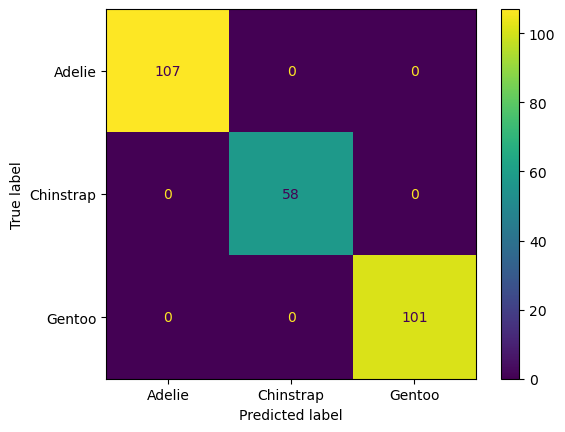

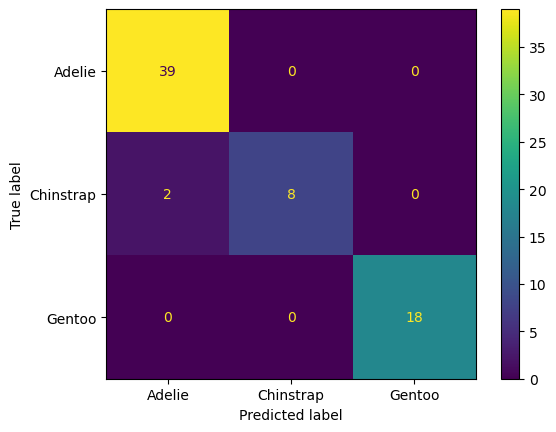

In [124]:
# Note: let rf be the name your random forest object with the optimal max_features or change the name in exercise 12

# Fit the model for each value of max features and compute the oob score

max_features = np.array([2, 3, 4])

for m_feat in max_features:
    rf = RandomForestClassifier(n_estimators=10, max_features=m_feat, oob_score=True)
    rf.fit(X_train, y_train)
    print(f"max_features = {m_feat}, oob score = {rf.oob_score_}")

# Print the best model parameter 

# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(rf, X_train, y_train)
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

Seems like 2 is the best number of features since it has the lowest OOB error.

### Feature Importance <a id='feImport'></a> 

The fitted `RandomForestClassifier` also has an attribute `feature_importances_`, that reflects the relative rank (i.e. depth) and predictive power of a feature, averaged across all trees in the ensemble. For further details, see https://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation, and for an example, see https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.

Let's start by visualizing the feature importances for our pruned tree in exercise 7 (note: replace `clf` with the name of your tree from exercise 7, if not already called `clf`). Notice how this reflects the depth of the feature and impurity decrease.

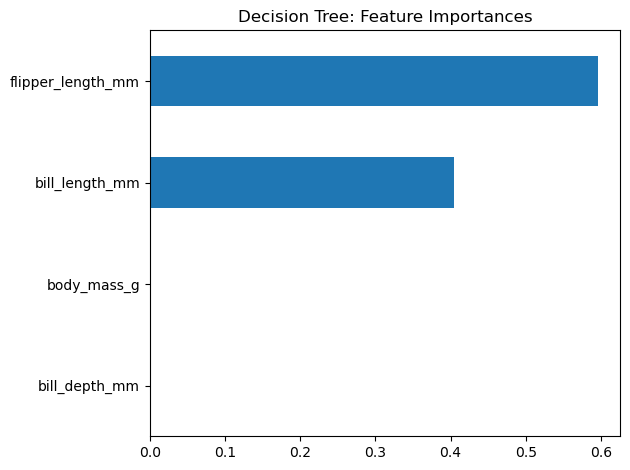

In [125]:
# NOTE: change clf to name of your pruned tree in exercise 7

# Extract feature names
feature_names = clf.feature_names_in_ 

# Create a pandas series with the feature importances
importances = pd.Series(
    clf.feature_importances_, index=feature_names
).sort_values(ascending=True)

# Plot the feature importances
ax = importances.plot.barh()
ax.set_title("Decision Tree: Feature Importances")
ax.figure.tight_layout()


### 🚩 Exercise 12 (CORE)

- Run the following code to plot the feature importance (averaged across all trees along with the standard deviation). 
- Visualize the correlation matrix of the features. 
- Has the ranking of the features changed comparing the pruned tree to the random forest? Does the correlation matrix provide any insight on why?

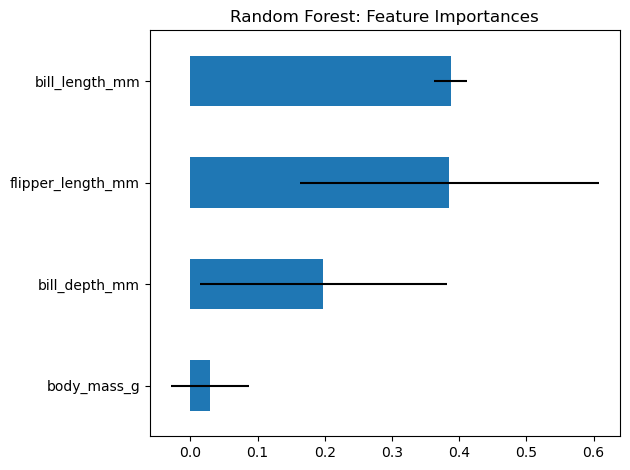

In [126]:
# Note: change rf to the name your random forest object in exercise 12

# Compute the standard deviation 
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create a pandas series with the feature importances
importances_rf = pd.Series(
    rf.feature_importances_, index=feature_names
).sort_values(ascending=True)

# Plot the feature importances
ax = importances_rf.plot.barh(xerr=std)
ax.set_title("Random Forest: Feature Importances")
ax.figure.tight_layout()

The ranking has definitely changed, the `bill_depth_mm` and `body_mass_g` variables now actually contribute to the model whereas in the pruned `clf` the did not.

In [127]:
# Plot the correlation matrix

## Voting Classifier

While bagging and random forests focused on creating an ensemble of the same estimator (e.g. trees) fit on different random subsets of the data, the idea behind **voting** is to combine different estimators. The predictions then can be aggregated either by using a majority vote or by averaging predicted probabilities (soft vote). This can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

In the `VotingClassifier`, the default is to aggregate predictions with **hard voting** (i.e. `voting='hard'` by default), which simply looks at the tally of votes received by each class across the estimators in the ensemble. Instead, **soft voting** (i.e. `voting='soft'`) averages the predicted probabilities across the estimators in the ensemble.

For further details, please see the documentation from here: https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

### 🚩 Exercise 13  (EXTRA)

- Create a voting classifier that combines your pruned tree, random forests, logistic regression, and support vector classifier.

- How does the accuracy on the test data compare across each model individually and the voting classifier?

In [128]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Fit a logisitic regression with no penalty


# Fit a SVC


# Fit a voting classifier


In [129]:
# Compute and print scores


# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name. If you are unable to edit the Notebook Metadata, please add a Markdown cell at the top of the notebook with your name(s).

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF. Once generated, please submit this PDF on Learn page by 16:00 PM on the Friday of the week the workshop was given. 

In [130]:
!jupyter nbconvert --to pdf mlp_week08.ipynb 

[NbConvertApp] Converting notebook mlp_week08.ipynb to pdf
[NbConvertApp] Writing 80149 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 104381 bytes to mlp_week08.pdf
